# Individual learning

[Wolfram Barfuss](https://wbarfuss.github.io) | [University of Bonn](https://www.uni-bonn.de) | 2024/2025 <br>
▶ **Complex Systems Modeling of Human-Environment Interactions**

## Motivation

> Give a man a fish, and he'll eat for a day

> Teach a man to fish, and he'll eat for a lifetime

> Give a man a taste for fish, and he'll eat even if conditions change. [[source](https://www.coursera.org/lecture/fundamentals-of-reinforcement-learning/michael-littman-the-reward-hypothesis-q6x0e)]

In this chapter, we will introduce the basics of temporal-difference reward-prediction reinforcement learning.

### Using behavioral theories in ABMs is challenging

General **agent-based modeling** is a flexible tool for studying different theories of human behavior. However, the social and behavioral sciences are not known for their tendency to integrate. **Knowledge about human behavior is fragmented into many different, context-specific, and often not formalized theories**. For example, in an attempt to order and use this knowledge for sustainability science, Constantino and colleagues presented a selection of 32 behavioral theories [@ConstantinoEtAl2021]. 

![](images/04.02-BehavioralTheories.dio.png)

The many behavioral theories pose a significant **challenge for general agent-based modeling** when it comes to incorporating human decision-making into models of Nature-society systems [@SchluterEtAl2017]:

1) **Fragmentation of theories**: A vast array of theories on human decision-making is scattered across different disciplines, making it difficult to navigate and select relevant theories. Each theory often focuses on specific aspects of decision-making, leading to **fragmented knowledge**.
2) **Incomplete theories**: The degree of formalization varies across theories. Many decision-making theories are incomplete or not fully formalized, requiring modelers to fill logical gaps with assumptions to make simulations work. This step introduces more degrees of freedom and possibly arbitrariness into the modeling process.
3) **Correlation-based theories**: Many theories focus on correlations rather than causal mechanisms, essential for dynamic modeling. This requires modelers to make explicit assumptions about causal relationships - introducing more degrees of freedom and possibly arbitrariness into the modeling process.
4) **Context-dependent theories**: The applicability of theories can vary greatly depending on the context, which adds complexity to their integration into models.

### Reinforcement learning offers a principled take

Reinforcement learning (RL) offers a general prototype model for intelligent & adaptive decision-making in agent-based models.

**Principle**

> "Do more of what makes you happy."

**We do not need to specify the behavior of an agent** directly.

**Instead, we specify what an agent wants** and how it learns. Crucially, how it learns does not depend on the details of the environment model. It is a more general process, applicable across different environments.

**Then, it learns for itself what to do** and we study the learning process and the learned behaviors.

This approach is **particularly valuable** for studying human-environment systems **when the decision environment changes** through a policy intervention or a global change process, like climate change or biodiversity loss. If we had specified the agent's behavior directly, the agent's behavior could not change when the environment changes. In contrast, if we specify the underlying agent's goal, we can study how the agent's behavior changes when the environment changes.  Reinforcement learning agents can **learn while interacting** with the environment.

### An integrating platform for cognitive mechanisms

RL, broadly understood, offers an interdisciplinary platform for integrating **cognitive mechanisms** into ABMs. It offers a comprehensive framework for studying the interplay among **learning** (adaptive behavior), **representation** (beliefs), and **decision-making** (actions) [@BotvinickEtAl2020].

![RL-based frameworks with cognitive mechanisms](images/04.02-CognitiveFrameworks.dio.png)

Collective or multi-agent reinforcement learning is a natural extension of RL to study the emerging **collective behavior** of multiple agents in dynamic environments. It allows for formulating hypotheses on how different **cognitive mechanisms** affect **collective behavior** in **dynamic environments** [@BarfussEtAl2024a].

RL is also an **interdisciplinary endeavor**, studied in Psychology, Neuroscience, Behavioral economics, Complexity science, and Machine learning.

![Reinforcement learning in the brain](images/04.02-DopamineRewardPredictionError.dio.png){#fig-RLinBrain}

@fig-RLinBrain shows the **remarkable analogy between the firing patterns of dopamine neurons in the brain and the prediction errors in a reinforcement learning simulation**. 

@fig-RLinBrain (a-c) shows prediction errors in a Pavlovian RL conditioning task simulation. A conditional stimulus (CS) is presented randomly, followed 2 seconds later by a reward (Unconditional Stimulus - US). (a) In the early training phase, the reward is not anticipated, leading to prediction errors when the reward is presented. As learning occurs, these prediction errors begin to affect prior events in the trial (examples from trials 5 and 10) because predictive values are learned. (b) After learning, the previously unexpected reward no longer creates a prediction error. Instead, the conditional stimulus now causes a prediction error when it occurs unexpectedly. (c) When the reward is omitted when expected, it results in a negative prediction error, signaling that what happened was worse than anticipated. 

@fig-RLinBrain (d–f) Firing patterns of dopamine neurons in monkeys engaged in a similar instrumental conditioning task [SchultzEtAl1997]. Each raster plot shows action potentials (dots) with different rows for different trials aligned with the cue (or reward) timing. Histograms show combined activity across the trials below. (d) When a reward is unexpectedly received, dopamine neurons fire rapidly. (e) After conditioning with a visual cue (which predicted a food reward if the animal performed correctly), the reward no longer triggers a burst of activity; now, the burst happens at the cue's presentation. (f) If the food reward is omitted unexpectedly, dopamine neurons exhibit a distinct pause in firing, falling below their typical rate. 

**Source of confusion.** Because of its broad scope and interdisciplinary nature, simply the phrase "reinforcement learning" can mean different things to different people. To mitigate this possible source of confusion, it is good to acknowledge that RL can refer to a **model of human learning**, an **optimization method**, a **problem description**, and a **field of research**.

### Learning goals

After this chapter, students will be able to:

- Explain why reinforcement learning is valuable in models of human-environment interactions 
- Implement and apply the different elements of the multi-agent environment framework, including a temporal-different learning agent.
- Explain and manage the trade-off between exploration and exploitation.
- Visualize the learning process 
- Use the Python library `pandas` to manage data
- Refine their skills in object-oriented programming
   

In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive
import matplotlib.animation as animation
from IPython.display import HTML
import sympy as sp
from copy import deepcopy

import matplotlib.style as style; style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 4)
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]  # get the first color of the default color cycle
plt.rcParams['axes.facecolor'] = 'white'; plt.rcParams['grid.color'] = 'gray'; 
plt.rcParams['grid.linewidth'] = 0.25; 
plt.rcParams['figure.dpi'] = 140

## Elements of the multi-agent environment interface
Generally, making sense of an agent without its environment is difficult, and vice versa.

![Reinforcement learning in the multi-agent environment interface](images/04.02-MAEiRLFrame.dio.png){#fig-MAEiRLFrame}

#### Interface
At the interface between agents and the environment are

* each agent's **set of** (conceivable) **actions** - from agents to environment,
* extrinsic **reward signals** - a single number from environment to each agent,
* possibly **observation signals** - from environment to agents.

Note: In general, the environment is composed of the *natural* and the *social* environment.

In [2]:
def interface_run(agents, env, NrOfTimesteps):
    """Run the multi-agent environment for several time steps."""

    observations = env.observe()
    
    for t in range(NrOfTimesteps):
                
        actions = [agent.act(observations[i])
            for i, agent in enumerate(agents)]
        
        next_observations, rewards, info = env.step(actions)

        for i, agent in enumerate(agents):
            agent.update(observations[i], actions[i], rewards[i], next_observations[i])

        observations = next_observations                

#### Environment
The environment delivers **extrinsic rewards** (motivations) to the agents based on the **agents' chosen actions** (choices).
It may contain environmental **states**, which may not be fully **observable** to the agents



The most common **environment classes**:

|  | Agents | Environment | Observation |
| ---- | ---- | ---- | ---- |
| **Multi-armed bandit** | one | no states | - |
| **Normal-form game** | multiple | no states | - |
| **Markov decision process** | one | multiple states | full |
| **Stochastic/Markov games** | multiple | multiple states | full |
| **Partially observable Markov decision process** | one | multiple states | partial |
| **Partially observable stochastic games** | multiple | multiple states | partial |

In all cases, **reward signals** may be **stochastic** and or **multi-dimensional**.

In [3]:
class Environment:
    """Abstract environment class."""
    
    def obtain_StateSet(self):
        """Default state set representation `state_s`."""
        return [str(s) for s in range(self.Z)]

    def obtain_ActionSets(self):
        """Default action set representation `action_a`."""
        return [str(a) for a in range(self.M)]
        
    def step(self, 
             jA # joint actions
            ) -> tuple:  # (observations_Oi, rewards_Ri, info)
        """
        Iterate the environment one step forward.
        """
        # choose a next state according to transition tensor T
        tps = self.TransitionTensor[tuple([self.state]+list(jA))].astype(float)
        next_state = np.random.choice(range(len(tps)), p=tps)
    
        # obtain the current rewards
        rewards = self.RewardTensor[tuple([slice(self.N),self.state]
                                          +list(jA)+[next_state])]
    
        # advance the state and collect info
        self.state = next_state
        obs = self.observe()     
    
        # report the true state in the info dict
        info = {'state': self.state}
    
        return obs, rewards.astype(float), info

    def observe(self):
        """Observe the environment."""
        return [self.state for _ in range(self.N)]
        

#### Agents

Agents act (oftentimes to reach a goal). We need to specify their

- **Actions**, describing which choices are available to the agent.
- **Goal**, describing what an agent wants (in the long run). They may contain *intrinsic motivations*.
- **Representation**, e.g., defining upon which conditions agents select actions (e.g., *history* of past actions in multi-agent situations).
- **Value beliefs** (value functions), capturing what is *good* for the agent regarding its *goal* in the long run.
- **Behavioral rule** (policy, strategy), defining how to select actions.
- **Learning rule**, describing how value beliefs are updated in light of new information.
- (optionally), a **model** of the environment and rewards.  Models are used for *planning*, i.e., deciding on a *behavioral rule* by considering possible future situations before they are actually experienced.


In [4]:
class BehaviorAgent:
    
    def __init__(self, policy):
        self.policy_Xoa = policy / policy.sum(-1, keepdims=True)
        self.ActionIxs = range(self.policy_Xoa.shape[1])
        
    def act(self, obs):
        return np.random.choice(self.ActionIxs, p=self.policy_Xoa[obs])

    def update(self, *args, **kwargs):
        pass

## Example | Risk Reward Dilemma

![Risk Reward Dilemma](images/03.01-RiskRewardDilemma.dio.png)

In [10]:
class RiskRewardDilemma(Environment):
    """A simple risk-reward dilemma environment."""

    def obtain_StateSet(self):
        return ['p', 'd']  # prosperous, degraded

    def obtain_ActionSets(self):
        return [['c', 'r']]  # cautious, risky

### Transitions | Environmental dynamics

The **environmental dynamics**, i.e., the transitions between environmental state contexts are modeled by two parameters: a collapse probability, $p_c$, and a recovery probability, $p_r$.

In [11]:
pc, pr = sp.symbols('p_c p_r')
pc

p_c

In [12]:
p = RiskRewardDilemma().obtain_StateSet().index('p')
d = RiskRewardDilemma().obtain_StateSet().index('d')
c = RiskRewardDilemma().obtain_ActionSets()[0].index('c')
r = RiskRewardDilemma().obtain_ActionSets()[0].index('r')
p,d,c,r    

(0, 1, 0, 1)

We implement the transitions as a three-dimensional array or **tensors**, with dimensions $Z \times M \times Z$, where $Z$ is the number of states and $M$ is the number of actions.

In [13]:
T = np.zeros((2,2,2), dtype=object)

The cautious action guarantees to remain in the prosperous state, $T(\mathsf{p,c,p})=1$. Thus, the agent can avoid the risk of environmental collapse by choosing the cautious action, $T(\mathsf{p,c,d})=0$.

In [14]:
T[p,c,d] = 0
T[p,c,p] = 1   

The risky action risks the collapse to the degraded state, $T(\mathsf{p,r,d}) = p_c$, with a collapse probability $p_c$. Thus, with probability $1-p_c$, the environment remains prosperous under the risky action, $T(\mathsf{p,r,p}) = 1-p_c$.

In [15]:
T[p,r,d] = pc
T[p,r,p] = 1-pc

At the degraded state, recovery is only possible through the cautious action, $T(\mathsf{d,c,p})=p_r$, with recovery probability 
$p_r$. Thus, with probability $1-p_r$, the environment remains degraded under the cautious action, $T(\mathsf{d,c,d})=1-p_r$.

In [16]:
T[d,c,p] = pr
T[d,c,d] = 1-pr

Finally, the risky action at the degraded state guarantees a lock-in in the degraded state, $T(\mathsf{d,r,d})=1$. Thus, the environment cannot recover from the degraded state under the risky action, $T(\mathsf{d,r,p})=0$. 

In [17]:
T[d,r,p] = 0
T[d,r,d] = 1

Last, we make sure that our transition tensor is normalized, i.e., the sum of all transition probabilities from a state-action pair to all possible next states equals one, $\sum_{s'} T(s, a, s') = 1$.

In [18]:
T.sum(-1)

array([[1, 1],
       [1, 1]], dtype=object)

All together, the transition tensor looks as follows:

In [19]:
sp.Array(T)

[[[1, 0], [1 - p_c, p_c]], [[p_r, 1 - p_r], [0, 1]]]

Recap | **Substituting parameter values**. In this chapter, we defined the transition and reward tensors as general `numpy` arrays with data types `object`, which we filled with symbolic expressions from `sympy`. To manipulate and substitute these expressions, we can use the `sympy.subs` method, however, not directly on the `numpy` array. Instead, we define a helper function `substitute_in_array` that takes a `numpy` array and a dictionary of substitutions and returns a new array with the substitutions applied.

In [20]:
def substitute_in_array(array, subs_dict):
    result = array.copy()
    for index,_ in np.ndenumerate(array):
        if isinstance(array[index], sp.Basic):
            result[index] = array[index].subs(subs_dict)
    return result

To make this work, it seems to be of critical importance that the subsitution dictionary is given as a dictionary in the form of `{<symbol_variable>: <subsitution>, ...}` and *not* as `dict(<symbol_variable>=<subsitution>, ...)`. For example, 

In [21]:
substitute_in_array(T, {pc: 0.1, pr: 0.05}).astype(float)

array([[[1.  , 0.  ],
        [0.9 , 0.1 ]],

       [[0.05, 0.95],
        [0.  , 1.  ]]])

With the help of the `substitue_in_array` function we give the risk-reward dilemma class its environmental dynamics:

In [22]:
def create_TransitionTensor(self):
    """Create the transition tensor."""
    return substitute_in_array(T, {pc: self.pc, pr: self.pr}).astype(float)
    
RiskRewardDilemma.create_TransitionTensor = create_TransitionTensor

### Rewards | Short-term welfare
The rewards or welfare the agent receives represent the ecosystem services the environment provides. It is modeled by three parameters: a safe reward $r_s$, a risky reward $r_r>r_s$, and a degraded reward $r_d<r_s$. We assume the following default values,

In [23]:
rs, rr, rd = sp.symbols('r_s r_r r_d')

We implement the rewards as a four-dimensional array or **tensor**, with dimensions $N \times Z \times M \times Z$, where $N=1$ is the number of agents, $Z$ is the number of states and $M$ is the number of actions. The additional agent dimension is necessary to accommodate multi-agent environments.

In [24]:
R = np.zeros((1,2,2,2), dtype=object)

The cautious action at the prosperous state guarantees the safe reward, $R(\mathsf{p,c,p}) = r_s$,

In [25]:
R[0,p,c,p] = rs

The risky action at the prosperous leads to the risky reward if the environment does not collapse, $R(\mathsf{p,r,p}) = r_r$,

In [26]:
R[0,p,r,p] = rr

Yet, whenever the environment enters, remains, or leaves the degraded state, it provides only the degraded reward $R(\mathsf{d,:,:}) = R(\mathsf{:,:,d}) = r_d$, where $:$ denotes all possible states and actions.

In [27]:
R[0,d,:,:] = R[0,:,:,d] = rd

Together, the reward tensor looks as follows:

In [28]:
sp.Array(R)

[[[[r_s, r_d], [r_r, r_d]], [[r_d, r_d], [r_d, r_d]]]]

Again, we use the `substitute_in_array` function to give the risk-reward dilemma class its reward function:

In [29]:
def create_RewardTensor(self):
    """Create the reward tensor."""
    return substitute_in_array(
        R, {rr: self.rr, rs: self.rs, rd: self.rd}).astype(float)
    
RiskRewardDilemma.create_RewardTensor = create_RewardTensor

### Init method

In [30]:
def __init__(self, CollapseProbability, RecoveryProbability, 
             RiskyReward, SafeReward, DegradedReward, state=0):
    self.N = 1; self.M = 2; self.Z = 2
    
    self.pc = CollapseProbability
    self.pr = RecoveryProbability
    self.rr = RiskyReward
    self.rs = SafeReward
    self.rd = DegradedReward

    self.StateSet = self.obtain_StateSet()
    self.ActionSets = self.obtain_ActionSets()
    self.TransitionTensor = self.create_TransitionTensor()
    self.RewardTensor = self.create_RewardTensor()
    
    self.state = state
RiskRewardDilemma.__init__ = __init__

Basic testing

In [31]:
env = RiskRewardDilemma(0.11, 0.4, 1.0, 0.8, 0.0)
env.TransitionTensor

array([[[1.  , 0.  ],
        [0.89, 0.11]],

       [[0.4 , 0.6 ],
        [0.  , 1.  ]]])

In [32]:
env.RewardTensor

array([[[[0.8, 0. ],
         [1. , 0. ]],

        [[0. , 0. ],
         [0. , 0. ]]]])

In [33]:
env.step([1])

([0], array([1.]), {'state': 0})

### Testing the interface

In [34]:
agent = BehaviorAgent(policy=np.ones((2,2)))
env = RiskRewardDilemma(0.2, 0.1, 1.0, 0.8, 0.0)
interface_run([agent], env, 10)

Obviously, this is not very insightful. We need to track the learning process.

We need to track the learning process. We can do this by storing the actions, observations, and rewards in a `pandas` DataFrame. Pandas is a powerful data manipulation library in Python that provides data structures and functions to work with structured data. We will store the data of each time step into a row and its attributes into a set of respective columns of the DataFrame. 

In [35]:
def interface_run(agent, env, NrOfTimesteps):
    """Run the multi-agent environment for several time steps."""

    columns = ["action", "observation", "reward"]
    df = pd.DataFrame(index=range(NrOfTimesteps), columns=columns)

    observations = env.observe()
    
    for t in range(NrOfTimesteps):
                
        action = agent.act(observations[0])
        
        next_observations, rewards, info = env.step([action])

        agent.update(observations[0], action, 
                     rewards[0], next_observations[0])

        df.loc[t] = (action, observations[0], rewards[0])
        
        observations = next_observations

    return df

In [36]:
df = interface_run(agent, env, 25)
df.tail()

,action,observation,reward
20,0,0,0.8
21,0,0,0.8
22,0,0,0.8
23,1,0,1.0
24,1,0,0.0


In [37]:
def plot_ActionsRewardsObservations(df):
    fig, axes = plt.subplots(3,1, figsize=(10,5))
    
    axes[0].plot(df.action, 'o', label='Agent 0')
    axes[0].set_ylabel('Action')
    axes[0].set_yticks([0, 1])
    axes[0].set_yticklabels([env.ActionSets[0][0], env.ActionSets[0][1]])
    
    axes[1].plot(df.reward, 'o', label='Agent 0');
    axes[1].set_ylabel('Reward')
    
    axes[2].plot(df.observation, 'o', label='Agent 0');
    axes[2].set_ylabel('Observation')
    axes[2].set_yticks([0, 1])
    axes[2].set_yticklabels([env.StateSet[0], env.StateSet[1]]);

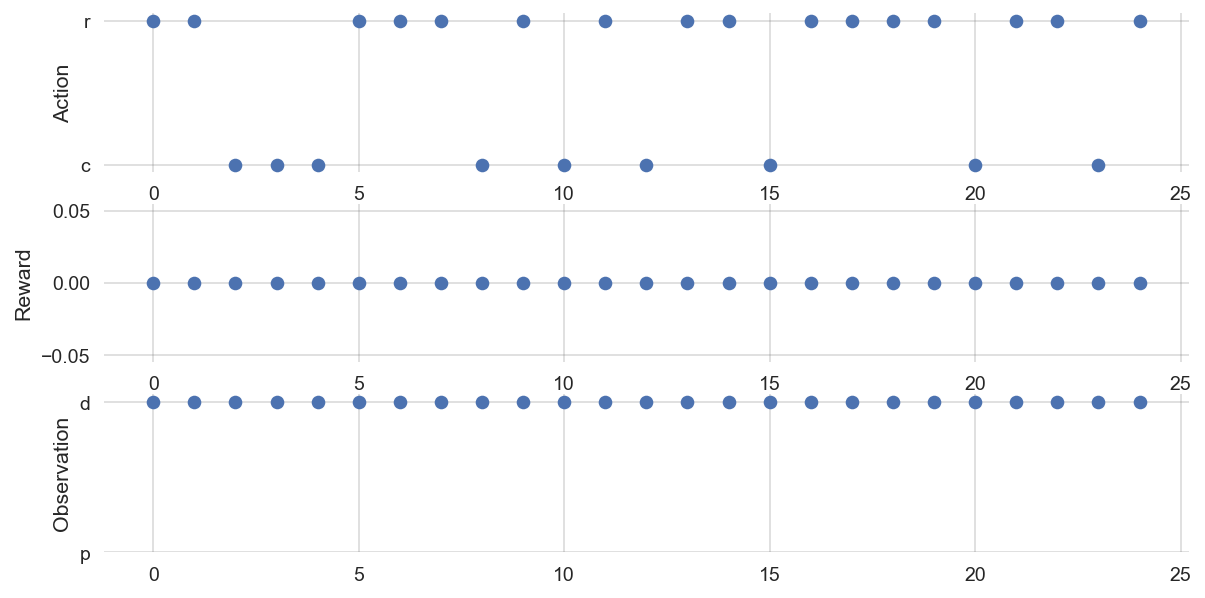

In [38]:
#| fig-cap: "Action-Reward-Observation Dynamics"
df = interface_run(agent, env, 25); plot_ActionsRewardsObservations(df)

## Reinforcement learning agent

Agents act (oftentimes to reach a goal). We need to specify their

- **Actions**, describing which choices are available to the agent.
- **Goal**, describing what an agent wants (in the long run). They may contain *intrinsic motivations*.
- **Representation**, e.g., defining upon which conditions agents select actions (e.g., *history* of past actions in multi-agent situations).
- **Value beliefs** (value functions), capturing what is *good* for the agent regarding its *goal* in the long run.
- **Behavioral rule** (policy, strategy), defining how to select actions.
- **Learning rule**, describing how value beliefs are updated in light of new information.
- (optionally), a **model** of the environment and rewards.  Models are used for *planning*, i.e., deciding on a *behavioral rule* by considering possible future situations before they are actually experienced.


Agents act (oftentimes to reach a goal). As in Lecture [03.01-SequentialDecision](03.01-SequentialDecisions.ipynb), the agent aims to maximize the discounted sum of future rewards,

$$ G_t = (1-\gamma) \sum_{\tau=0}^\infty \gamma^\tau R_{t+\tau},$$

where $1-\gamma$ is a normalizing factor and $R_{t+\tau+1}$ is the reward received at time step $t+\tau+1$.

However, in contrast to Lecture [03.01-SequentialDecision](03.01-SequentialDecisions.ipynb), we assume that the agent does **not know the environment's dynamics and rewards**. Instead, the agent **learns** about the environment **while interacting** with it. 

The challenge is that actions may have **delayed** and **uncertain** consequences.

**Delayed** consequences mean that an action may influence the environmental state, which, in turn, influences the reward the agent receives at a later time step. For example, in our risk-reward dilemma, opting for a sustainable policy may initially reduce the agent's immediate reward but ensures a comparably higher long-term welfare.
**Uncertain** consequences refer to the **stochasticity** in the environmental transitions (and possibly the reward signals themselves). For example, in our risk-reward dilemma, the risky action in the prosperous state may lead to a high reward
but may also cause a transition to the degraded state. Moreover, uncertainty may also refer to the fact that the environmental transition dynamics may change over time.

Thus, the agent can’t just try each action in each state once and then immediately know which course of action is best. It **must learn** the best course of action **over successive trials**, each of which gives possible noisy data.

We start implement the learning class by defining `__init__` method.

In [39]:
class Learner():
    """A simple reinforcement learning agent."""   

    def __init__(self, ValueBeliefs_Qoa,
                 DiscountFactor, LearningRate, ChoiceIntensity):

        self.DiscountFactor = self.df = DiscountFactor
        self.LearningRate = self.lr = LearningRate
        self.ChoiceIntensity = self.ci = ChoiceIntensity

        self.ValueBeliefs_Qoa = ValueBeliefs_Qoa
        
        self.ActionIxs = range(ValueBeliefs_Qoa.shape[1])

The agent receives the following parameters: the initial value beliefs `ValueBeliefs_Qoa`, the discount factor `DiscountFactor`, the learning rate `LearningRate`, and the choice intensity `ChoiceIntensity`.
Furthermore, we give the agent an attribute `ActionIxs` that stores the indices of the possible actions. This will be helpful when selecting actions.

### Value beliefs

The general strategy we focus on to solve the challenges of delayed and uncertain consequences is to let the agent **learn value beliefs**. Value beliefs are the agent's estimates of the long-term value of each action $a$ in each state $s$. The agent then uses these value beliefs to select actions. These estimates are also often called Q values. You may think of the *quality* of an action $a$ in state $s$ which tells the agents Which action to select in which state.


For example, in our risk-reward dilemma, we can represent the agent’s value beliefs by

In [40]:
ValueBeliefs_Qoa = 10 * np.random.rand(2,2)
ValueBeliefs_Qoa

array([[8.83140215, 5.58254363],
       [8.59330674, 1.20765508]])

The challenge of uncertain consequences in then solved by an appropriate **behavioral rule** which handles the so-called **exploration-exploitation trade-off**  

The challenge of delayed consequences is solved by the **learning rule**, which updates the value beliefs in light of new information using the Bellman equation, as in Lecture [03.01-SequentialDecisions](03.01-SequentialDecisions.ipynb).

### Behavioral rule | Exploration-exploitation trade-off

The **exploration-exploitation trade-off** poses **a fundamental problem for decision-making under uncertainty**. 

**Under too much exploitation**, the agent may pick an action that is not optimal, as it has not yet sufficiently explored all possible actions. It acts under the false belief that its current value beliefs are already correct or optimal. Thus, it *loses out* on possible rewards it would have gotten if it had explored more and discovered that a different course of action is better.

**Under too much exploration**, the agent may continue to try all actions to gain as much information about the transitions and reward distributions as possible. It is *losing out* because it never settles on the best course of action, continuing to pick all actions until the end.

What is needed is a **behavioral rule** that **balances exploitation and exploration** to explore enough to find the best option but not too much so that the best option is exploited as much as possible.

We use the so-called *softmax* function,

$$x(s, a) = \frac{\exp \beta Q(s, a)}{\sum_{b \in \mathcal A}\exp \beta Q(s, b)},$$

which converts any set of value beliefs into probabilities that sum to one. 

The higher the relative value belief, the higher the relative probability.

In [41]:
def obtain_softmax_probabilities(ChoiceIntensity, ValueBeliefs):
    expValueBeliefs = np.exp(ChoiceIntensity*np.array(ValueBeliefs))
    return expValueBeliefs / expValueBeliefs.sum(-1, keepdims=True)

The softmax function contains a parameter $\beta$, denoting the **choice intensity** (sometimes called *inverse temperature*, that determines how **exploitative** (or *greedy*) the agent is.

When $\beta = 0$, arms are chosen entirely at random with no influence of the Q values. This is super exploratory, as the agent continues to choose all arms irrespective of observed rewards. 

In [42]:
obtain_softmax_probabilities(0, ValueBeliefs_Qoa)

array([[0.5, 0.5],
       [0.5, 0.5]])

As $\beta$ increases, there is a higher probability of picking the arm with the highest Q value. This is increasingly exploitative (or ‘greedy’). 

In [43]:
obtain_softmax_probabilities(1, ValueBeliefs_Qoa)

array([[9.62632074e-01, 3.73679265e-02],
       [9.99380298e-01, 6.19702179e-04]])

When $\beta$ is very large, then only the arm that currently has the highest Q value will be chosen, even if other arms might actually be better.

In [44]:
obtain_softmax_probabilities(50, ValueBeliefs_Qoa).round(9)

array([[1., 0.],
       [1., 0.]])

For example, assuming we are in state zero and using $\beta=1$, we can select an action by

In [45]:
obs = 0
Xoa = obtain_softmax_probabilities(1, ValueBeliefs_Qoa)
np.random.choice([0,1], p=Xoa[obs])

0

We summarize this logic in the agent's `act` method:

In [46]:
def act(self, obs):
    Xoa = self.obtain_policy_Xoa()
    return np.random.choice(self.ActionIxs, p=Xoa[obs])
Learner.act = act

where we define the `ActionIxs` as `range(self.NrActions)` in the `__init__` method of the agent. We also define the `obtain_policy_Xoa` method in the agent class:

In [47]:
def obtain_policy_Xoa(self):
    return obtain_softmax_probabilities(self.ChoiceIntensity, self.ValueBeliefs_Qoa)
Learner.obtain_policy_Xoa = obtain_policy_Xoa

**Testing** the `act` and `obtain_policy_Xoa` methods:

In [48]:
learner = Learner(np.ones((2,2)), 0.9, 0.1, 1.0)

In [49]:
learner.obtain_policy_Xoa()[0]

array([0.5, 0.5])

Selecting action uniformly at random for 1000 times should give a mean index of approx. 0.5:

In [50]:
np.mean([learner.act(0) for _ in range(1000)])

0.479

### Learning rule | Temporal-difference learning

The learning rule solves the challenge of delayed consequences. The value beliefs are updated using the Bellman equation in light of new information. As the Bellman equation describes how state(-action) values relate at different timesteps, this reinforcement learning update class is called **temporal-difference learning**.

Given an observed state $s$, the agent selects an action $a$ and receives a reward $r$.
Then, the agent updates its value beliefs (for state-action pair $s$-$a$) according to

$$Q_{t+1}(s, a) = Q_{t}(s, a) + \alpha\left((1-\gamma)r + \gamma \sum_b x_t(s', b) Q_t(s',b) - Q_{t}(s, a)
\right).$$ {#eq-RLupdate}

**DeepDive** | There is some freedom into designing the specifics of the temporal-difference update, especially regarding estimating the value of the next state or observation. The specific update used above is called **Expected SARSA**. It is beyond the scope of this course to discuss the different temporal-difference learning algorithms. The interested reader is referred to excellent material on (multi-agent) reinforcement learning, e.g., [@SuttonBarto2018; @AlbrechtEtAl2024]. 

The extent to which the value beliefs are updated is controlled by a second parameter, $\alpha \in (0, 1)$, called the **learning rate**.

When $\alpha=0$, there is no updating, and the reward does not affect value beliefs,

$$Q_{t+1}(s, a) = Q_{t}(s, a) =: \text{old estimate}.$$

The value belief update always remains the *old estimate* of the value beliefs.

When $\alpha = 1$,  the value belief for the state-action pair ($s, a$) becomes a discount-factor weighted average between the current reward $r$ and the expected value of the next state $\sum_b x_t(s', b) Q_t(s',b)$, 

$$Q_{t+1}(s, a) = (1-\gamma)r + \gamma \sum_b x_t(s', b) Q_t(s',b) =: \text{new estimate}.$$

The value belief update is entirely determined by the *new estimate* of the value beliefs, which is the current reward received $r$ plus the discount factor $\gamma$ multiplied by the expected value of the following state $\sum_b x_t(s', b) Q_t(s',b)$, and adequately normalized with the prefactor $(1-\gamma)$.


When $0 < \alpha < 1$, the new value belief for the rewarded arm is a *weighted average* between old value belief and new reward information,

\begin{align}
Q_{t+1}(s, a) &= (1-\alpha) \ \text{old estimate} &+ &\alpha \ \text{new estimate}\\
&= (1-\alpha) \ Q_{t}(s, a) &+ &\alpha \left((1-\gamma)r + \gamma \sum_b x_t(s', b) Q_t(s',b)\right).
\end{align}


Once more, we face a trade-off. 
Clearly, setting $\alpha = 0$ is ineffective since the agent does not acquire knowledge. 
Yet, if $\alpha$ is excessively high; the agent tends to *forget* previously learned state-action information.

**Temporal-difference reward-prediction error**. Another way to think about the update equation (@eq-RLupdate) is as follows: The value beliefs are updated by the *temporal-difference reward-prediction error* (TDRP error) times the learning rate. The TDRP error equals the difference between the *new estimate* and the *old estimate* of the value beliefs. If the TDRP error is zero, the agent correctly predicted the next reward, and thus, no further adjustments in the value beliefs are necessary.

\begin{align}
Q_{t+1}(s, a) &= Q_{t}(s, a) + \alpha \qquad\qquad\qquad\qquad\qquad \text{TDRP-error}, \\
&= Q_{t}(s, a) + \alpha \Big( \qquad \qquad   \text{new estimate} \qquad \qquad \ - \text{old estimate} \Big), \\
&= Q_{t}(s, a) + \alpha \Big( (1-\gamma)r + \gamma \sum_b x_t(s', b) Q_t(s',b) - \quad Q_{t}(s, a) \quad \Big)
\end{align}


**DeepDive** | The exact terminology *temporal-difference reward-prediction error* is used rather rarely. We use it here to express the interdisciplinary nature of temporal-difference reward-prediction learning. In machine learning, the term *temporal-difference error* is more common. It describes the difference between the predicted and the observed reward. In psychology and neuroscience, the term *reward-prediction error* is used in the context of the brain's dopamine system, where it is thought to signal the difference between the expected and the observed reward. The term *temporal-difference reward-prediction error* combines both terms, expressing the idea that the agent learns by predicting future rewards.

Executing the value belief update in Python may look like

In [51]:
def update(self, 
           obs: int,
           action: int,
           reward: float,
           next_obs: int,
          ):
    """Updates the value beliefs / Q-value of an action."""

    temporal_difference =self.obtain_temporal_difference(
        obs, action, reward, next_obs)
    
    self.ValueBeliefs_Qoa[obs, action] = (
        self.ValueBeliefs_Qoa[obs, action] + self.LearningRate * temporal_difference
    )

Learner.update = update

We program the `update` method highly modular. It calls the `obtain_temporal_difference` method to compute the temporal-difference error and then updates the value beliefs accordingly. The `obtain_temporal_difference` method is defined as follows:

In [52]:
def obtain_temporal_difference(self,
                               obs: int,
                               action: int,
                               reward: float,
                               next_obs: int,
                              ):
    """Compute temporal-difference eorror"""
    next_Qoa = self.obtain_nextQoa(next_obs)
    new_estimate = (1-self.DiscountFactor) * reward + self.DiscountFactor * next_Qoa
    old_estimate = self.ValueBeliefs_Qoa[obs][action]
    return new_estimate - old_estimate
Learner.obtain_temporal_difference = obtain_temporal_difference

In here, we call the `obtain_nextQoa` method to compute the expected value of the next state. The `obtain_nextQoa` method is defined as follows:

In [53]:
def obtain_nextQoa(self, next_obs: int):
    policy_Xoa = self.obtain_policy_Xoa()
    return np.sum(policy_Xoa[next_obs] * self.ValueBeliefs_Qoa[next_obs])
Learner.obtain_nextQoa = obtain_nextQoa

**Testing the update method**: First, let's assume the agent does not care about future rewards at all and has a discount factor of zero

In [54]:
learner = Learner(ValueBeliefs_Qoa = np.ones((2,2)), 
                  DiscountFactor = 0.0,
                  LearningRate = 0.1,
                  ChoiceIntensity = 1.0)

In [55]:
learner.ValueBeliefs_Qoa

array([[1., 1.],
       [1., 1.]])

Let's assume the agent selected the action with index `0` after observing the state with index `0`, received a reward of zero, and observed the next state with index `1`.

In [56]:
learner.update(obs=0, action=0, reward=0, next_obs=1)
learner.ValueBeliefs_Qoa.round(4)

array([[0.9, 1. ],
       [1. , 1. ]])

The value belief for the action `0` in state `0` is updated exactly as a learning rate weighted average: $\alpha \cdot \text{new estimate} + (1-\alpha) \cdot \text{old estimate}$ $= \alpha 0 + (1-\alpha) 1$ $= 0.1 \cdot 0 + 0.9 \cdot 1$.

Repeating this update a hundred more time steps updates the value beliefs for the action `0` in state `0` to the expected value of zero.

In [57]:
for _ in range(100): learner.update(obs=0, action=0, reward=0, next_obs=1)
learner.ValueBeliefs_Qoa.round(4)

array([[0., 1.],
       [1., 1.]])

Now, we repeat that test, but with an agent with a discount factor of $\gamma=0.8$.

In [58]:
learner = Learner(ValueBeliefs_Qoa = 1*np.ones((2,2)), 
                  DiscountFactor = 0.8,
                  LearningRate = 0.1,
                  ChoiceIntensity = 1.0)

In [59]:
learner.ValueBeliefs_Qoa

array([[1., 1.],
       [1., 1.]])

In [60]:
for _ in range(100): learner.update(obs=0, action=0, reward=0, next_obs=1)
learner.ValueBeliefs_Qoa.round(4)

array([[0.8, 1. ],
       [1. , 1. ]])

Now, the value belief for the action `0` in state `0` is updated to $0.8$. Can you explain why?

We have convince ourselves that the learner's `update` methods works as we expect. 

Now, we are ready to let it learn in the risk-reward dilemma environment.

### Testing the interface

In [61]:
learner = Learner(ValueBeliefs_Qoa = np.ones((2,2)), 
                  DiscountFactor = 0.9,
                  LearningRate = 0.1,
                  ChoiceIntensity = 1.0)
print(learner.obtain_policy_Xoa())

env = RiskRewardDilemma(CollapseProbability=0.2, RecoveryProbability=0.1, 
                        SafeReward=0.8, RiskyReward=1.0, DegradedReward=0.0)

print(" - - - - ")
df = interface_run(learner, env, 10000)
print(" - - - - ")

print(learner.obtain_policy_Xoa())

[[0.5 0.5]
 [0.5 0.5]]
 - - - - 
 - - - - 
[[0.5091271  0.4908729 ]
 [0.50860671 0.49139329]]


The learning agent's policy changed. However, not too much. We know from Lecture [03.01-SequentialDecisions](03.01-SequentialDecisions.ipynb) that the agent should learn to prefer the cautious action in both states under these parameter settings. 

**Try re-executing the above cell while make some changes to the parameters. Can you get an intuition what is important for a successful learning process?**

The process of finding the right parameters for the agent is called **hyperparameter tuning**. It is a crucial step in machine learning and often requires a lot of trial and error. 

**From a modeling point of view**, we aim to go beyond finding the *right* parameter. We aim to **understand** how the parameters influence the learning process. 

Comparing the initial with the final policy is not the best way to facilitate both aims. We need a more refined way to keep track of the learning process.

## Investigating the learning process

To keep track of the learning process, we store the value beliefs and the policy in a `pandas` DataFrame. Aditionally, we also record the learning rate and the choice intensity.

In [62]:
def interface_run(agent, env, NrOfTimesteps):
    """Run the multi-agent environment for several time steps."""

    columns = ["action", "observation", "reward", "beliefs", "policy",
               "ChoiceIntensity", "LearningRate"]
    df = pd.DataFrame(index=range(NrOfTimesteps), columns=columns)

    observations = env.observe()
    
    for t in range(NrOfTimesteps):
                
        action = agent.act(observations[0])
        
        next_observations, rewards, info = env.step([action])

        agent.update(observations[0], action, 
                     rewards[0], next_observations[0])

        df.loc[t] = (action, next_observations[0], rewards[0],
                     deepcopy(agent.ValueBeliefs_Qoa), 
                     deepcopy(agent.obtain_policy_Xoa()),
                     deepcopy(agent.ChoiceIntensity), 
                     deepcopy(agent.LearningRate))

        observations = next_observations

    return df

In [63]:
learner = Learner(ValueBeliefs_Qoa = 0*np.ones((2,2)), 
                  DiscountFactor = 0.9,
                  LearningRate = 0.05,
                  ChoiceIntensity = 8.0)

print(learner.obtain_policy_Xoa())

env = RiskRewardDilemma(CollapseProbability=0.2, RecoveryProbability=0.1, 
                        SafeReward=0.8, RiskyReward=1.0, DegradedReward=0.0)

df = interface_run(learner, env, 10000)

[[0.5 0.5]
 [0.5 0.5]]


As we stored the value beliefs and policies as two-dimensional `numpy` arrays, we convert them into three-dimensional `numpy` with time running on the first dimension:

In [64]:
beliefs_Qtoa = np.array(df.beliefs.values.tolist())
policy_Xtoa = np.array(df.policy.values.tolist())
beliefs_Qtoa.shape, policy_Xtoa.shape

((10000, 2, 2), (10000, 2, 2))

We include these conversions into a plotting function that visualizes the learning process

In [65]:
def plot_learning_process(df, plot_varying_parameters=False):
    beliefs_Qtoa = np.array(df.beliefs.values.tolist())
    policy_Xtoa = np.array(df.policy.values.tolist())
    beliefs_Qtoa.shape, policy_Xtoa.shape

    fig = plt.figure(figsize=(14,6))
    
    ax0 = fig.add_subplot(311)
    ax0.plot(beliefs_Qtoa[:,p,c], label='Q(p,c)', color='blue', lw=2)
    ax0.plot(beliefs_Qtoa[:,p,r], label='Q(p,r)', color='red', lw=2)
    ax0.plot(beliefs_Qtoa[:,d,c], label='Q(d,c)', color='darkblue', ls='--')
    ax0.plot(beliefs_Qtoa[:,d,r], label='Q(d,r)', color='darkred', ls='--')
    ax0.set_ylabel('Value beliefs');
    ax0.legend(loc='center right'); ax0.set_xlim(-10, len(df)*1.1)
    
    ax1 = fig.add_subplot(312, sharex=ax0)
    ax1.plot(policy_Xtoa[:,p,c], label='X(p,c)', color='blue', lw=2)
    ax1.plot(policy_Xtoa[:,p,r], label='X(p,r)', color='red', lw=2)
    ax1.plot(policy_Xtoa[:,d,c], label='X(d,c)', color='darkblue', ls='--')
    ax1.plot(policy_Xtoa[:,d,r], label='X(d,r)', color='darkred', ls='--')
    ax1.set_ylabel('Policy'); ax1.set_xlabel('Time steps')
    ax1.legend(loc='center right')

    if plot_varying_parameters:
        ax2 = fig.add_subplot(615, sharex=ax0)
        ax2.plot(df.LearningRate, label='LearningRate', color='k')
        ax2.set_ylabel("Learning\nRate")
        
        ax3 = fig.add_subplot(616, sharex=ax0)
        ax3.plot(df.ChoiceIntensity, label='ChoiceIntensity', color='k')
        ax3.set_ylabel("Choice\nIntensity"), ax3.set_xlabel('Time steps')
        
    # plt.tight_layout()
    plt.subplots_adjust(hspace=0.35)
    
    # plt.legend()
    ax0.set_ylim(0, 1);

### To little exploitation | To much exploration

In [66]:
learner = Learner(ValueBeliefs_Qoa = 0*np.ones((2,2)), 
                  DiscountFactor = 0.9,
                  LearningRate = 0.1,
                  ChoiceIntensity = 1.0)

env = RiskRewardDilemma(CollapseProbability=0.2, RecoveryProbability=0.1, 
                        SafeReward=0.8, RiskyReward=1.0, DegradedReward=0.0)

df = interface_run(learner, env, 10000)

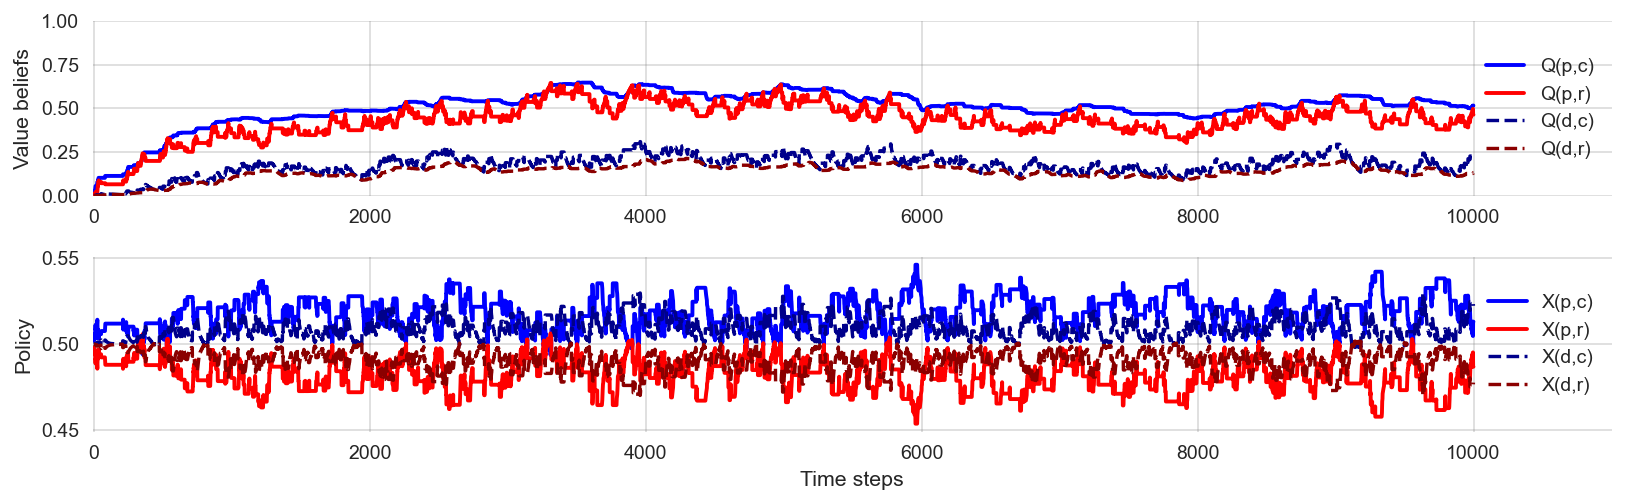

In [67]:
#| fig-cap: "Learning the risk-reward dilemma with to much exploration."
plot_learning_process(df)

The order of the **value beliefs** seems roughly **consistent with** the **optimal policy**, that prefers the cautious action over the risky on in both states. However, the **agents policy is fluctuating around**. The action choice probabilities are fluctuating around their uniformly random value of 0.5. This is a sign that the agent explores too much and exploits too little. 

### To much exploitation | To little exploration

In [68]:
learner = Learner(ValueBeliefs_Qoa = 0*np.ones((2,2)), 
                  DiscountFactor = 0.9,
                  LearningRate = 0.1,
                  ChoiceIntensity = 100.0)

env = RiskRewardDilemma(CollapseProbability=0.2, RecoveryProbability=0.1, 
                        SafeReward=0.8, RiskyReward=1.0, DegradedReward=0.0)

df = interface_run(learner, env, 10000)

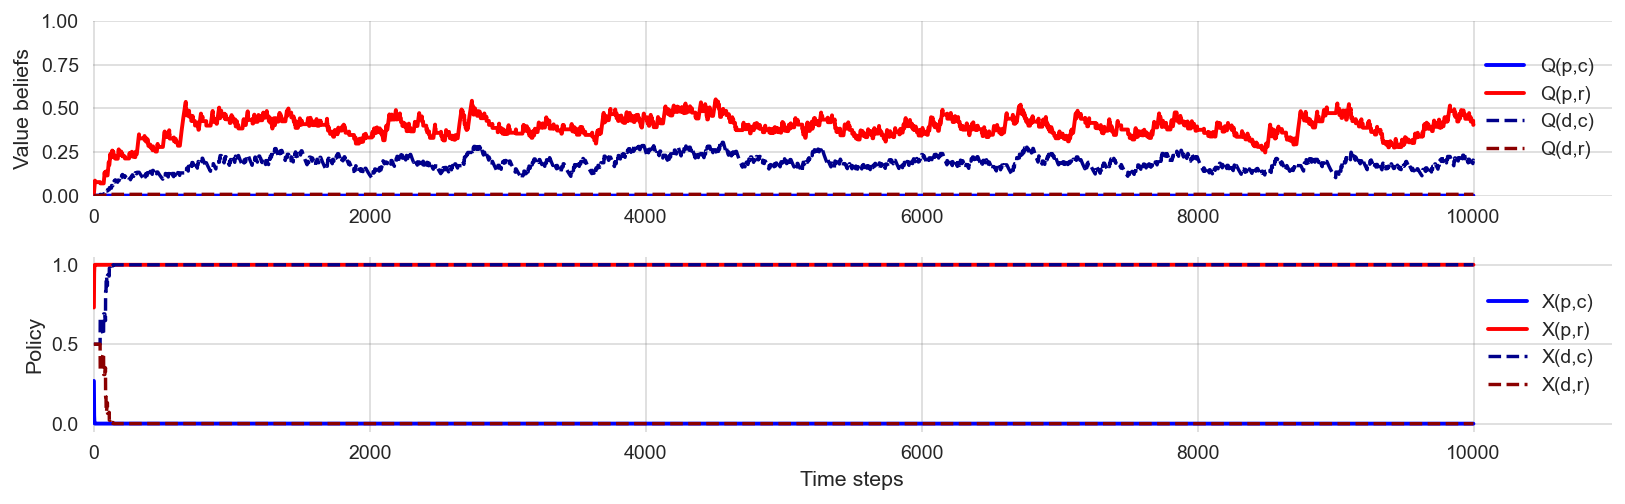

In [69]:
#| fig-cap: "Learning the risk-reward dilemma with to much exploitation."
plot_learning_process(df)

Increasing the choice intensity leads to a more exploitative policy. However, what the agent learns depends on the stochasticity of the learning process. **Try to convince yourself of that fact by re-executing the above cell multiple times.** 

In other words, the agent may not learn the optimal policy. To little exploration harms the learning.

### Decaying exploration | Increasing exploitation 

To mitigate the negative effects of too much exploration towards the end of the learning process and the negative effects of too much exploitation towards the beginning of the learning process, we could let the choice intensity increase over time. This is called **decaying exploration**.

We implement this idea by creating a new agent class `AdjustingLearner` that inherits from the `Learner` class. This shows the power of object-oriented programming. We overwrite the `update` method to include an increasing choice intensity. We also make the learning rate decay over time.

In [70]:
class AdjustingLearner(Learner):

    def __init__(self, 
                 ValueBeliefs_Qoa, 
                 DiscountFactor, 
                 LearningRate, MinLearningRate, LearningRateDecayFactor,
                 ChoiceIntensity, MaxChoiceIntensity, ChoiceIntensityGrowthFactor,
                ):

        self.DiscountFactor = DiscountFactor
        
        self.LearningRate = LearningRate
        self.MinLearningRate = MinLearningRate
        self.LearningRateDecayFactor = LearningRateDecayFactor
        
        self.ChoiceIntensity = ChoiceIntensity
        self.MaxChoiceIntensity = MaxChoiceIntensity
        self.ChoiceIntensityGrowthFactor = ChoiceIntensityGrowthFactor

        self.ValueBeliefs_Qoa = ValueBeliefs_Qoa
        self.ActionIxs = range(ValueBeliefs_Qoa.shape[1])

In [71]:
def update(self, 
           obs: int,
           action: int,
           reward: float,
           next_obs: int,
          ):
    """Updates the value beliefs / Q-value of an action."""

    temporal_difference =self.obtain_temporal_difference(
        obs, action, reward, next_obs)
    
    self.ValueBeliefs_Qoa[obs, action] = (
        self.ValueBeliefs_Qoa[obs, action] + self.LearningRate * temporal_difference
    )

    self.LearningRate = max(self.MinLearningRate, 
                            self.LearningRate * self.LearningRateDecayFactor)
    self.ChoiceIntensity = min(self.MaxChoiceIntensity, 
                               self.ChoiceIntensity * self.ChoiceIntensityGrowthFactor)

AdjustingLearner.update = update

Now, we are ready to perform a new learning simulation.

In [72]:
learner = AdjustingLearner(ValueBeliefs_Qoa = 0*np.ones((2,2)), 
                           DiscountFactor = 0.9,
                           LearningRate = 0.1, MinLearningRate = 0.01, LearningRateDecayFactor = 0.999,
                           ChoiceIntensity = 1.0, MaxChoiceIntensity = 50.0, ChoiceIntensityGrowthFactor = 1.001)

env = RiskRewardDilemma(CollapseProbability=0.2, RecoveryProbability=0.1, 
                        SafeReward=0.8, RiskyReward=1.0, DegradedReward=0.0)

df = interface_run(learner, env, 10000)

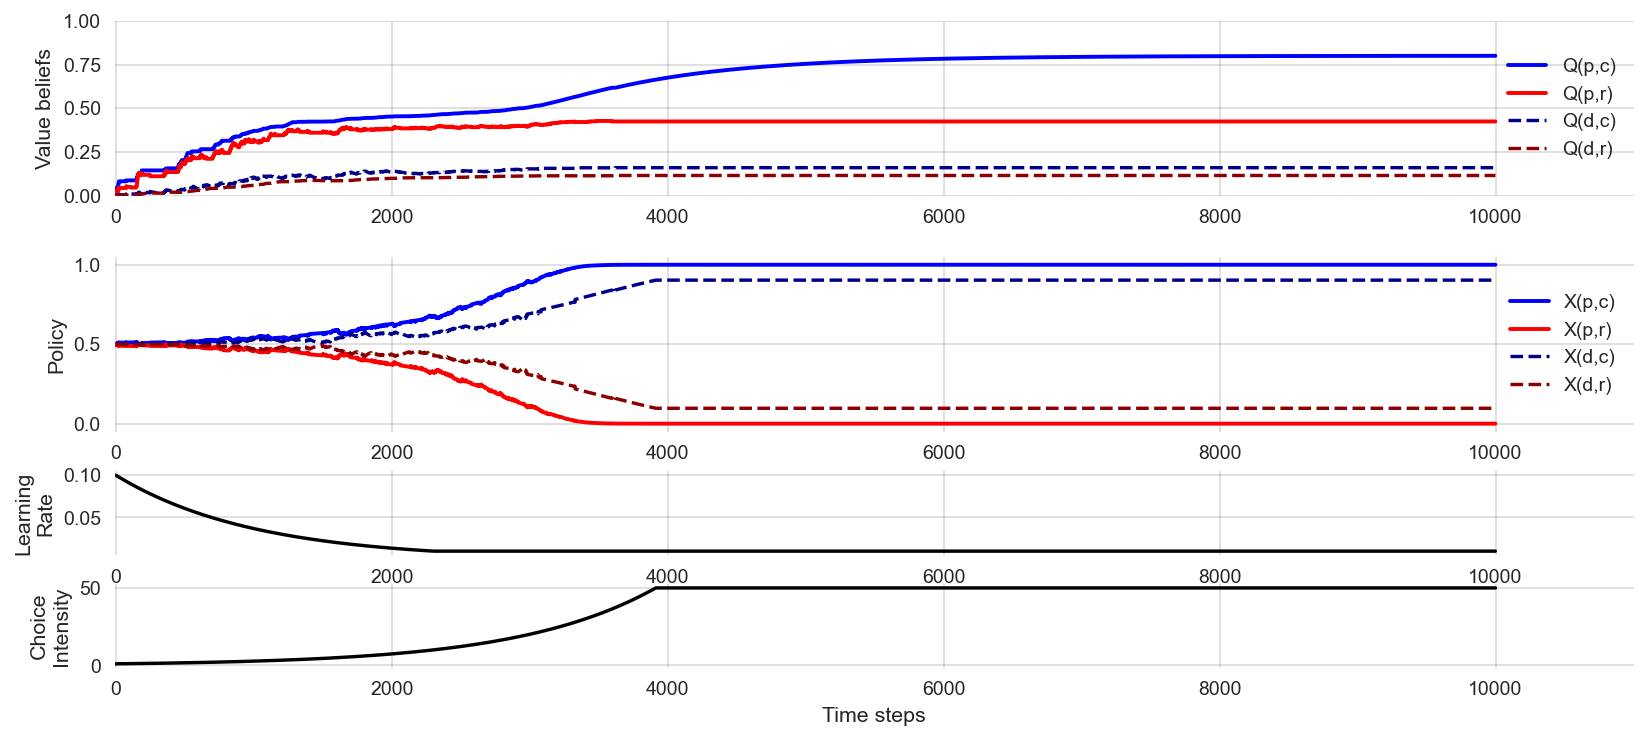

In [73]:
#| fig-cap: "Learning the risk-reward dilemma with an increasing choice intensity."
plot_learning_process(df, plot_varying_parameters=True)

We find the `AdjustingLearner` is able to consitently learn the optimal policy. **Try to convince yourself that this is true by re-executing the simulation above multiple times.** We also find that it learns the optimal policy in approx. less than 4000 time steps. **How does the learning process depend on the additional parameters?**


Obviously, the `AdjustingLearner` is a more complex agent than the `Learner`. There is also a prominent *trick* to give our simpler `Learner` agent an initial exploration bonus.

### Initial exploration bonus

We can give the agent an initial exploration bonus by setting the initial value beliefs to a high value. This is called **optimistic initialization**. 

In [74]:
learner = Learner(ValueBeliefs_Qoa = 8*np.ones((2,2)), 
                  DiscountFactor = 0.9,
                  LearningRate = 0.1,
                  ChoiceIntensity = 60.0)

env = RiskRewardDilemma(CollapseProbability=0.2, RecoveryProbability=0.1, 
                        SafeReward=0.8, RiskyReward=1.0, DegradedReward=0.0)

df = interface_run(learner, env, 10000)

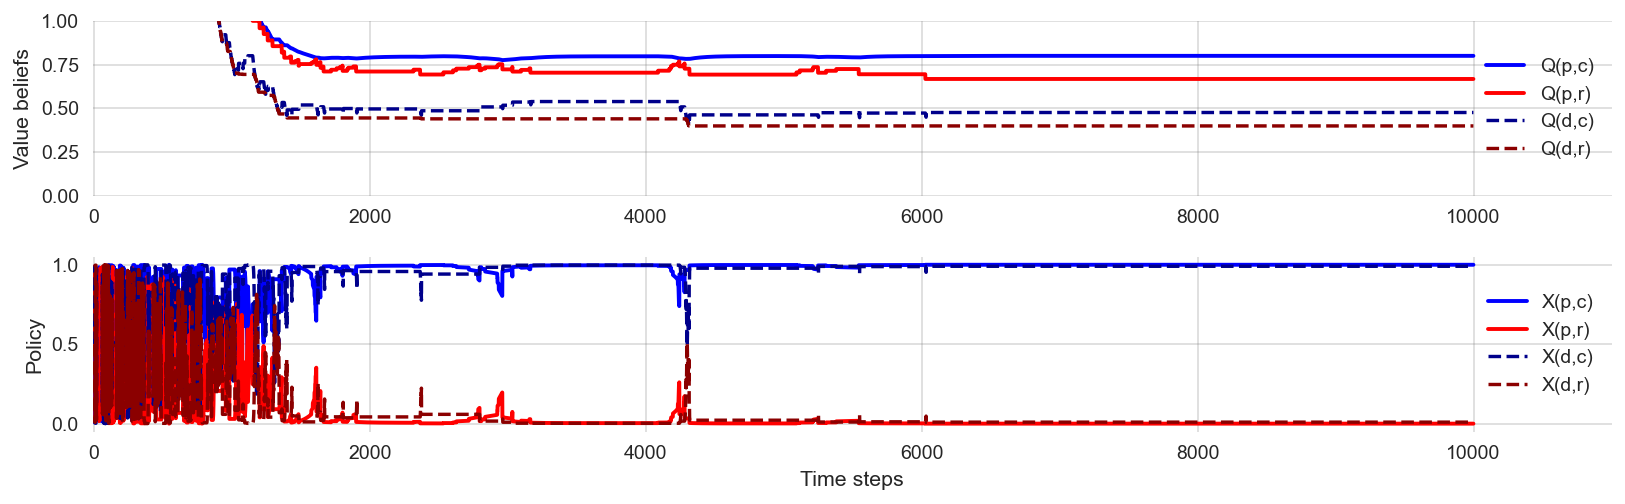

In [75]:
#| fig-cap: "Learning the risk-reward dilemma with an initial exploration bonus."
plot_learning_process(df)

So far, we have investigated the learning process in a single environment. 

Next, we will explore learning in normal-form games to illustrate the modularity of the agent-environment interface, utilizing the same learning agents as previously discussed.

## Multi-agent environments | Games

### Interface


First, we adjust the `interface_run` function to work with the multi-agent environment.

We can make the *columns* of a dataframe adaptive to the number of agents. 

In [76]:
NrAgents = 2; NrOfTimesteps = 4

def create_dataframe(NrAgents, NrOfTimesteps):
    columns = list(np.array([(f"action{i}", f"observation{i}", f"reward{i}",
                              f"beliefs{i}", f"policy{i}", 
                              f"ChoiceIntensity{i}", f"LearningRate{i}") 
                             for i in range(NrAgents)]).flatten())
    
    return pd.DataFrame(index=range(NrOfTimesteps), columns=columns)

create_dataframe(NrAgents, NrOfTimesteps)

,action0,observation0,reward0,beliefs0,policy0,ChoiceIntensity0,LearningRate0,action1,observation1,reward1,beliefs1,policy1,ChoiceIntensity1,LearningRate1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We also write a function to populate the DataFrame with the values of the learning process.

In [77]:
def fill_dataframe(actions, next_observations, rewards, agents):
    data = []
    for i in range(len(agents)):
        data += [actions[i], next_observations[i], rewards[i],
                 deepcopy(agents[i].ValueBeliefs_Qoa), 
                 deepcopy(agents[i].obtain_policy_Xoa()),
                 deepcopy(agents[i].ChoiceIntensity), 
                 deepcopy(agents[i].LearningRate)]
    return data

Adjusting the `interface_run` function to work with the multi-agent environment yields a clean and readable implementation.

In [78]:
def interface_run(agents, env, NrOfTimesteps):
    """Run the multi-agent environment for several time steps."""
    df = create_dataframe(len(agents), NrOfTimesteps)

    observations = env.observe()
    
    for t in range(NrOfTimesteps):
                
        actions = [agent.act(observations[i])
            for i, agent in enumerate(agents)]

        next_observations, rewards, info = env.step(actions)

        for i, agent in enumerate(agents):
            agent.update(observations[i], actions[i], rewards[i], next_observations[i])
    
        df.loc[t] = fill_dataframe(actions, next_observations, rewards, agents)

        observations = next_observations
    
    return df

Testing whether it works in our previous environment, the risk-reward dilemma looks promising.

In [79]:
learner = Learner(ValueBeliefs_Qoa = 8*np.ones((2,2)), 
                  DiscountFactor = 0.9,
                  LearningRate = 0.1,
                  ChoiceIntensity = 60.0)

env = RiskRewardDilemma(CollapseProbability=0.2, RecoveryProbability=0.1, 
                        SafeReward=0.8, RiskyReward=1.0, DegradedReward=0.0)

# Note: we need to pass the learner as a list of agents
df = interface_run([learner], env, 4) 

In [80]:
df

,action0,observation0,reward0,beliefs0,policy0,ChoiceIntensity0,LearningRate0
0,1,0,1.0,"[[8.0, 7.93], [8.0, 8.0]]","[[0.9852259683067277, 0.014774031693272396], [...",60.0,0.1
1,0,0,0.8,"[[7.927906923600332, 7.93], [8.0, 8.0]]","[[0.46864505269071266, 0.5313549473092875], [0...",60.0,0.1
2,0,0,0.8,"[[7.8567279493493345, 7.93], [8.0, 8.0]]","[[0.012172569010807209, 0.9878274309891928], [...",60.0,0.1
3,1,0,1.0,"[[7.8567279493493345, 7.86061972818162], [8.0,...","[[0.4418871301229423, 0.5581128698770577], [0....",60.0,0.1


The real test, however, comes with a true multi-agent environment.

### Social dilemmas environment

Let's extend our treatment of reinforcement learning to **multiple agents**. 
From the perspective of each individual agent, other agents make the environment **non-stationary**. This can complicate reinforcement learning significantly.

We here focus on normal-form games and use the generic model of a social dilemma, introduced in Lecture [03.02-StrategicInteractions](03.02-StrategicInteractions.ipynb).

$$
\begin{array}{c|cc}
\text{} & \color{blue}{\mathsf{Abate}} & \color{blue}{\mathsf{Pollute}} \\
\hline
\color{red}{\mathsf{Abate}} & {\color{red}{1}} \ | \ {\color{blue}{1}} & {\color{red}{-1-F}} \ | \ {\color{blue}{+1+G}} \\
\color{red}{\mathsf{Pollute}} & {\color{red}{+1+G}} \ | \ {\color{blue}{-1-F}} & {\color{red}{-1}} \ | \ {\color{blue}{-1}} \\
\end{array}
$$

Depending on whether the greed $G$ and fear $F$ are positive or negative, we can distinguish four types of games @fig-social-dilemma-dimensions.

![Dimensions of a social dilemma with ordinal payoffs and Nash equilibira shown in boxes.](images/03.02-SocialDilemmaDimensions.dio.png){#fig-social-dilemma-dimensions}

In @fig-social-dilemma-dimensions, the payoff values are ordinal, meaning that only their order, $3>2>1>0$, is considered of relevance.

We also implement it as a class using the same interface as before and letting it inherit from our base environment.

In [81]:
class SocialDilemma(Environment):
    """A simple social dilemma environment."""

    def obtain_StateSet(self):
        return ['.']  # a dummy state

    def obtain_ActionSets(self):
        # abate, pollute for two agents
        return [['a', 'p'], ['a', 'p']]  

Due to the absence of environmental state transitions, the environment consistently exists in a single, effective dummy state. Consequently, the transition tensor is simplified significantly.

In [82]:
def create_TransitionTensor(self):
    """Create the transition tensor."""
    return np.ones((self.Z, self.M, self.M, self.Z))
    
SocialDilemma.create_TransitionTensor = create_TransitionTensor

The reward tensor is slighlty more complicated. The two defining parameters of the social dilemma environemtn are the greed $G$ and the fear $F$.

In [83]:
F, G = sp.symbols('F G')

We represent rewards using a five-dimensional tensor with dimensions $N \times Z \times M \times M \times Z$. Here, $N$ denotes the number of agents, $Z=1$ signifies the state count, and $M$ indicates the number of actions. A uni-dimensional state dimension is essential for accommodating multi-state environments.

In [84]:
R = np.zeros((2,1,2,2,1), dtype=object)

Helper variable for the indices facilitate the construction of the reward tensor.

In [85]:
a = SocialDilemma().obtain_ActionSets()[0].index('a')
p = SocialDilemma().obtain_ActionSets()[0].index('p')
a,p

(0, 1)

Mutual abatement yields a reward of one for both agents.


In [86]:
R[0, 0, a, a, 0] = R[1, 0, a, a, 0] = 1

Mutual pollution yields a reward of minus one for both agents.


In [87]:
R[0, 0, p, p, 0] = R[1, 0, p, p, 0] = -1

Pollution by one agent and abatement by the other agent yields a reward of one plus the greed for the polluting agent and minus the fear for the abating agent.

In [88]:
R[0, 0, p, a, 0] = R[1, 0, a, p, 0] = 1 + G
R[0, 0, a, p, 0] = R[1, 0, p, a, 0] = -1 - F

In sum, the reward tensor for agent zero reads,

In [89]:
sp.Array(R[0,0,:,:,0])

[[1, -F - 1], [G + 1, -1]]

and for agent one,

In [90]:
sp.Array(R[1,0,:,:,0])

[[1, G + 1], [-F - 1, -1]]

In [91]:
def create_RewardTensor(self):
    """Create the reward tensor."""
    return substitute_in_array(
        R, {F: self.Fear, G: self.Greed}).astype(float)
    
SocialDilemma.create_RewardTensor = create_RewardTensor

The two defining parameters of the social dilemma are the greed $G$ and the fear $F$.

In [92]:
def __init__(self, Greed, Fear):
    self.N = 2; self.M = 2; self.Z = 1
    
    self.Greed = Greed
    self.Fear = Fear
    
    self.StateSet = self.obtain_StateSet()
    self.ActionSets = self.obtain_ActionSets()
    self.TransitionTensor = self.create_TransitionTensor()
    self.RewardTensor = self.create_RewardTensor()
    
    self.state = 0
SocialDilemma.__init__ = __init__

### Testing the implementation:

In [93]:
env = SocialDilemma(Fear=0.65, Greed=0.75)

Mutual cooperation by two abating agents:

In [94]:
env.step([a,a])

([0, 0], array([1., 1.]), {'state': 0})

Mutual defection by two polluting agents:

In [95]:
env.step([p,p])

([0, 0], array([-1., -1.]), {'state': 0})

Different actions:

In [96]:
env.step([a,p])

([0, 0], array([-1.65,  1.75]), {'state': 0})

In [97]:
env.step([p,a])

([0, 0], array([ 1.75, -1.65]), {'state': 0})

Testing whether the implementation works,

In [98]:
learner1 = Learner(ValueBeliefs_Qoa = 8*np.ones((1,2)), 
                  DiscountFactor = 0.9,
                  LearningRate = 0.1,
                  ChoiceIntensity = 60.0)
learner2 = deepcopy(learner1)

env = SocialDilemma(Fear=1, Greed=2)

df = interface_run([learner1, learner2], env, 4) 
df

,action0,observation0,reward0,beliefs0,policy0,ChoiceIntensity0,LearningRate0,action1,observation1,reward1,beliefs1,policy1,ChoiceIntensity1,LearningRate1
0,1,0,3.0,"[[8.0, 7.95]]","[[0.9525741268224331, 0.047425873177566774]]",60.0,0.1,0,0,-2.0,"[[7.9, 8.0]]","[[0.0024726231566347743, 0.9975273768433652]]",60.0,0.1
1,0,0,-2.0,"[[7.899786583570701, 7.95]]","[[0.0468507276383191, 0.9531492723616809]]",60.0,0.1,1,0,3.0,"[[7.9, 7.94997774639159]]","[[0.047486230263144295, 0.9525137697368558]]",60.0,0.1
2,1,0,-1.0,"[[7.899786583570701, 7.860288271841277]]","[[0.9145029408174301, 0.08549705918256983]]",60.0,0.1,1,0,-1.0,"[[7.9, 7.860264375998088]]","[[0.9156096786764698, 0.08439032132353015]]",60.0,0.1
3,0,0,1.0,"[[7.830484788680395, 7.860288271841277]]","[[0.14329244697889626, 0.8567075530211037]]",60.0,0.1,0,0,1.0,"[[7.830698202813024, 7.860264375998088]]","[[0.14504926660635398, 0.854950733393646]]",60.0,0.1


throws no erros.

### Transient cooperation

In this section, we show that reinforcement learning agents can learn to cooperate in a tragedy social dilemma environment. However, this cooperation is not stable. It is only a transient phenomenon [@GollEtAl2024].

We use a social dilemma with fear $F=1$ and greed $G=2$.

In [99]:
env = SocialDilemma(Fear=1, Greed=2)

We want to give the agents an inital boost to cooperate or abate. Thus, we give them an inital higher value belief for abate than pollute.

In [100]:
learner1 = Learner(ValueBeliefs_Qoa = np.array([[0.5, -0.5]]), 
                   DiscountFactor = 0.9,
                   LearningRate = 0.01,
                   ChoiceIntensity = 5.0)

We assume the second agent to be identical to the first one.

In [101]:
learner2 = deepcopy(learner1)

In [102]:
np.random.seed(42)
df = interface_run([learner1, learner2], env, 20000) 

In [103]:
def plot_TwoAgentBeliefsPolicies(df):
    beliefs0_Qtoa = np.array(df.beliefs0.values.tolist())
    policy0_Xtoa = np.array(df.policy0.values.tolist())
    beliefs1_Qtoa = np.array(df.beliefs1.values.tolist())
    policy1_Xtoa = np.array(df.policy1.values.tolist())
    
    fig = plt.figure(figsize=(14,6))
    
    ax0 = fig.add_subplot(311); ax0.set_ylabel('Value beliefs');
    ax0.plot(beliefs0_Qtoa[:,0,a], label='Q1(a)', color='blue',lw=2)
    ax0.plot(beliefs0_Qtoa[:,0,p], label='Q1(p)', color='red', lw=2)
    ax0.plot(beliefs1_Qtoa[:,0,a], label='Q2(a)', color='darkblue', ls='--')
    ax0.plot(beliefs1_Qtoa[:,0,p], label='Q2(p)', color='darkred', ls='--')
    ax0.legend(loc='center right'); ax0.set_xlim(-10, len(df)*1.1)
    
    ax1 = fig.add_subplot(312, sharex=ax0); ax1.set_ylabel('Policy')
    ax1.plot(policy0_Xtoa[:,0,a], label='X1(a)', color='blue', lw=2)
    ax1.plot(policy0_Xtoa[:,0,p], label='X1(p)', color='red', lw=2)
    ax1.plot(policy1_Xtoa[:,0,a], label='X2(a)', color='darkblue', ls='--')
    ax1.plot(policy1_Xtoa[:,0,p], label='X2(p)', color='darkred', ls='--')
    ax1.set_xlabel('Time steps'); ax1.legend(loc='center right')


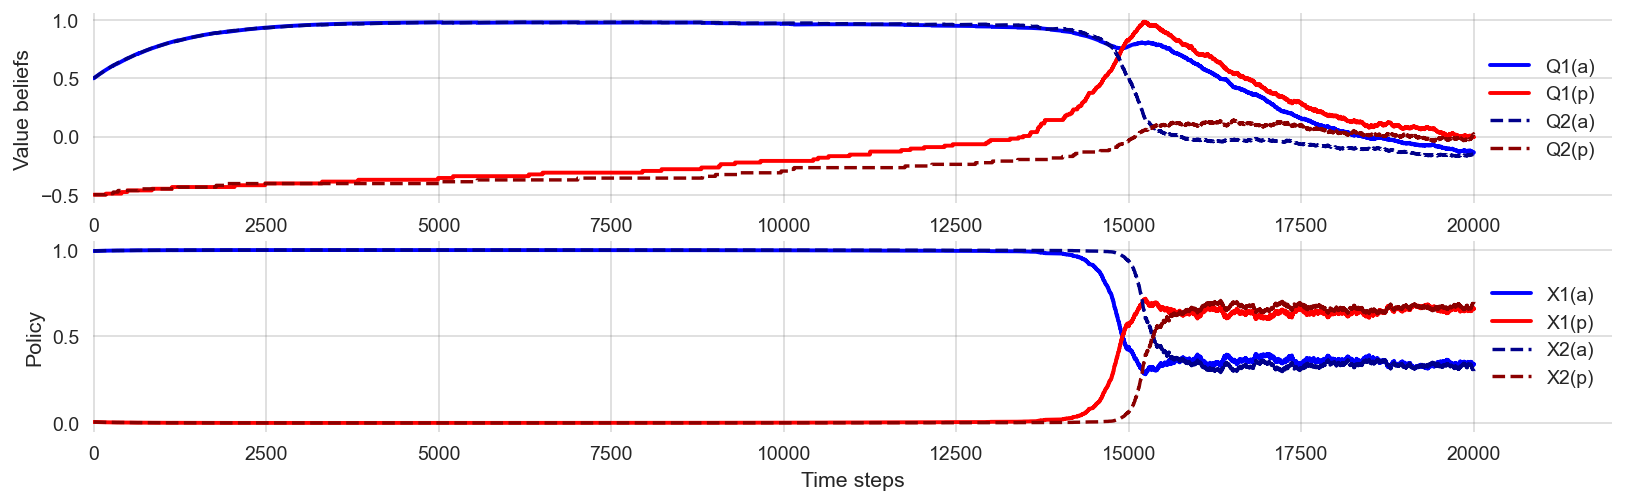

In [104]:
#| fig-cap: "Transient cooperation in a tragedy social dilemma."
plot_TwoAgentBeliefsPolicies(df)

A propensity for cooperation coupled with excessive exploitation initially leads to transient cooperation within the stochastic learning dynamics. If one is unaware of this phenomenon, it may seem that the issue of cooperation in social dilemmas is resolved. However, as learning continues, this cooperation phase diminishes, resulting in increased defection (pollution) over cooperation (abate). During this phase, agents explore excessively, necessitating a higher choice intensity to establish more deterministic policies that align with the Nash equilibrium of full defection.

The timeing of when the breakdown of cooperation happens is stochastic. **Re-run the simulation above with differnt random seeds to see that this is true**. Beaware, that you must re-initalize the learners to begin from scratch.

## Learning goals revisited


- Reinforcement learning is **valuable in models of human-environment interactions** as a principled take to integrate individual cognition in dynamic environments and emerging collective behavior
- We implemented the different elements of the multi-agent environment framework (interface, environment, agents).
    - We implemented and applied a **basic temporal-different learning** agent.
    - We implemented and applied the **risk-reward dilemma** (Lecture [03.01](03.01-SequentialDecisions.ipynb)) and **social dilemma** (Lecture [03.02](03.02-StrategicInteractions.ipynb))
    - We visualized the learning process
- We introduced and studied the **exploration-exploitation trade-off**, a general challenge for decision-making under uncertainty.
- We made all of this possible by using the Python library `pandas` to manage data and refining our skills in object-oriented programming.
 

### Key advantages of an RL framework

* Cognitive mechanisms are more integrated / less fragmented than behavioral theories
* Cognitive mechanisms (as in RL) are more formalized than behavioral theories
* The RL frame provides a natural dynamic extension to some economic equilibrium decision models. 
* The Rl frame allows for the study of behavior changes (e.g., after experimental policy interventions or environmental catastrophes)
  


### Challenges

- The **learning is inefficient**. The agents require many interactions with the environment to learn what to do as they do not learn any model of the environment. This is a cognitive wasteful process.
- Dealing with **rare states/events** is **challenging** when learning from only experience. Even more sample interactions are required to have enough experience of the raw events.
- The **stochasticity and hyperparameter tuning** make it a **cumbersome modeling tool**. Both elements are invaluable for RL as an optimization method. For RL as a model of the cognitive processes underpinning human behavior, stochasticity and hyperparameter tuning complicate the modeling process considerably. They make studying the learning dynamics more difficult than necessary.

Up next: Deterministic approximations

::: {.content-hidden unless-profile="standalone"}

## References

:::

::: {.content-hidden unless-profile="housekeeping"}

## Housekeeping

With the following cells, we can convert this notebook into slides and a PDF handout. If you work with this notebook interactively, you can ignore them.

---
metadata-files: [_standalone-quarto.yml]
---

In [105]:
#| output: false 
!cp 04.02-IndividualLearning.ipynb 04.02-IndividualLearning_.ipynb
!quarto render 04.02-IndividualLearning_.ipynb --to pdf --profile standalone
!mv 04.02-IndividualLearning_.pdf __scripts/04.02-IndividualLearning.pdf
!rm -r 04.02-IndividualLearning_*

pandoc 
  to: latex
  output-file: 04.02-IndividualLearning_.tex
  standalone: true
  pdf-engine: xelatex
  variables:
    graphics: true
    tables: true
    secnumdepth: 2
  default-image-extension: pdf
  metadata-files:
    - _standalone-quarto.yml
  toc-depth: 2
  
metadata
  documentclass: scrartcl
  classoption:
    - DIV=11
    - numbers=noendperiod
  papersize: A4
  header-includes:
    - '\KOMAoption{captions}{tableheading}'
  block-headings: false
  title: Individual learning
  bibliography:
    - CSMofHEI.bib
  geometry:
    - top=20mm
    - left=20mm
    - right=20mm
    - bottom=25mm
  link-citations: true
  number-depth: 2
  

Rendering PDF
running xelatex - 1
  This is XeTeX, Version 3.14159265-2.6-0.999992 (TeX Live 2020) (preloaded format=xelatex)
   restricted \write18 enabled.
  entering extended mode
  
running xelatex - 2
  This is XeTeX, Version 3.14159265-2.6-0.999992 (TeX Live 2020) (preloaded format=xelatex)
   restricted \write18 enabled.
  entering extended m

:::